In [1]:
import numpy as np
from numpy.random import choice

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F

import math

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

from scipy.integrate import odeint

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
mu = 1
nu = 0.01 # Kinematic viscosity coefficient

# Number of training initial conditions. Modify as necessary
num_samples = 3000  # 3000


# NOTE: We attribute the following code to generate Burger's eq. data from this repository:
# https://github.com/sachabinder/Burgers_equation_simulation/tree/main

np.random.seed(1)

# Prepare spatial mesh
L_x = 1
dx = 0.01
N_x = int(L_x/dx)
X = np.linspace(0,L_x,N_x)

# Prepare temporal mesh
L_t = 1.0
dt = 0.01
N_t = int(L_t/dt)
T = np.linspace(0,L_t,N_t)

#Wave number discretization
k = 2*np.pi*np.fft.fftfreq(N_x, d = dx)

# Burgers equation data for neural network input
u = torch.zeros(size=(N_x*num_samples,N_x))
v = torch.zeros(size=(N_x*num_samples,N_x))
t = torch.zeros(size=(N_x*num_samples,1))


uu = np.zeros(shape=(num_samples,N_x,N_t))


for num in range(num_samples):

  alpha = np.random.uniform(-1,1,1)
  beta = np.random.uniform(-1,1,1)
  u0 = alpha*np.sin(2*math.pi*X) + (beta)*(np.cos(2*math.pi*X))**3     # Initial condition


  def burg_system(u,t,k,mu,nu):
      u_hat = np.fft.fft(u)
      u_hat_x = 1j*k*u_hat
      u_hat_xx = -k**2*u_hat

      u_x = np.fft.ifft(u_hat_x)
      u_xx = np.fft.ifft(u_hat_xx)

      u_t = -mu*u*u_x + nu*u_xx
      return u_t.real


  u_i = odeint(burg_system, u0, T, args=(k,mu,nu,), mxstep=5000).T

  uu[num,:,:] = u_i

 # time_indices = np.random.randint(0, T.size, N_x)
  time_indices = np.arange(100)

  # Store created data
  # u stores initial condition (phi_0)
  # v stores solution (phi_t)
  u[num*N_x:(num+1)*N_x,0:N_x] = torch.from_numpy(u_i[:,0])
  t[num*N_x:(num+1)*N_x,0] = torch.from_numpy(T[time_indices])
  v[num*N_x:(num+1)*N_x,0:N_x] = torch.from_numpy(np.transpose(u_i[:,time_indices]))


In [3]:
# Convert data to appropriate structures and save to device

U = u.type(torch.float32).to(device)
V = v.type(torch.float32).to(device)
times = t.type(torch.float32).to(device)


# Sample times uniformly for physics-informed training in a collocation procedure

times_unif = np.random.uniform(0,1.0,size=(U.size(dim=0),1))
times_unif[0:num_samples] = 0  # Ensure sufficient sampling at the initial boundary (optional)
times_unif = torch.tensor(times_unif, requires_grad=True).type(torch.float32).to(device)

In [4]:
w = 120 # Neural network width

# Network mapping to domain that parameterizes the manifold
class parameterization_NN(nn.Module):
    def __init__(self):
        super(parameterization_NN, self).__init__()
        self.hidden_layer1 = nn.Linear(N_x,w,bias=True)
        self.hidden_layer2 = nn.Linear(w,w, bias=True); self.hidden_layer3 = nn.Linear(w,w, bias=True)
        self.output_layer = nn.Linear(w,2, bias=True)

    def forward(self, X):
        inputs = X
        layer1_out = F.gelu(self.hidden_layer1(inputs)); layer2_out = F.gelu(self.hidden_layer2(layer1_out))
        layer3_out = F.gelu(self.hidden_layer3(layer2_out))
        output = 2*np.pi*F.sigmoid(self.output_layer(layer3_out))
        # The sigmoid activation helps the domain have small measure, which ensures larger partial derivatives and overall helps learning
        # Scale as necessary. We choose 2pi since this constant is often used in parameterizing periodic geometries
        return output

In [5]:
# Riemannian metric neural network
class g_NN(nn.Module):
    def __init__(self):
        super(g_NN, self).__init__()
        self.hidden_layer1 = nn.Linear(3,w,bias=True)
        self.hidden_layer2 = nn.Linear(w,w, bias=True); self.hidden_layer3 = nn.Linear(w,w, bias=True)
        self.output_layer = nn.Linear(w,3, bias=True)

    def forward(self, uv, t):
        inputs = torch.cat((uv,t),1)
        layer1_out = F.gelu(self.hidden_layer1(inputs)); layer2_out = F.gelu(self.hidden_layer2(layer1_out))
        layer3_out = F.gelu(self.hidden_layer3(layer2_out))
        output = self.output_layer(layer3_out)
        output = torch.reshape(torch.column_stack((output[:,0], output[:,1], output[:,1], output[:,2])), (inputs.size(dim=0),2,2))
        return output

In [6]:
# Encoder network mapping to manifold under Ricci flow

class encoder_NN(nn.Module):
    def __init__(self):
        super(encoder_NN, self).__init__()
        self.hidden_layer1 = nn.Linear(3,w,bias=True)
        self.hidden_layer2 = nn.Linear(w,w, bias=True); self.hidden_layer3 = nn.Linear(w,w, bias=True)
        self.output_layer = nn.Linear(w,3, bias=True)

    def forward(self, uv, tau):
        inputs = torch.cat((uv, tau),1)
        layer1_out = F.gelu(self.hidden_layer1(inputs)); layer2_out = F.gelu(self.hidden_layer2(layer1_out))
        layer3_out = F.gelu(self.hidden_layer3(layer2_out))
        output = self.output_layer(layer3_out)
        return output

# Decodes the point along the manifold
class decoder_NN(nn.Module):
    def __init__(self):
        super(decoder_NN, self).__init__()
        self.hidden_layer1 = nn.Linear(3,w,bias=True)
        self.hidden_layer2 = nn.Linear(w,w, bias=True); self.hidden_layer3 = nn.Linear(w,w, bias=True)
        self.output_layer = nn.Linear(w,N_x, bias=True)

    def forward(self, xyz):
        inputs = xyz
        layer1_out = F.tanh(self.hidden_layer1(inputs)); layer2_out = F.tanh(self.hidden_layer2(layer1_out))
        layer3_out = F.tanh(self.hidden_layer3(layer2_out))
        output = self.output_layer(layer3_out)
        return output

In [7]:
# Declare networks

parameterization = parameterization_NN().to(device)
g = g_NN().to(device)
encoder = encoder_NN().to(device)
decoder = decoder_NN().to(device)

In [8]:
# Set Adam optimizer

optimizer = optim.Adam([
    {'params': parameterization.parameters()},
    {'params': g.parameters()},
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
], lr=5e-5)#, weight_decay=1e-7)

# Modify the learning rate as appropriate. We do not use an automatically-adjusted learning rate, but feel free to modify code if you'd like to do so

In [10]:
# Load in pre-trained neural networks from current directory

File = "parameterization.pth"
parameterization.load_state_dict(torch.load(File))

File = "g.pth"
g.load_state_dict(torch.load(File))

File = "encoder.pth"
encoder.load_state_dict(torch.load(File))

File = "decoder.pth"
decoder.load_state_dict(torch.load(File))

In [11]:
# Create function to get metric coefficients of the encoder neural network (not g)
def metric_of_encoder(encoder, uv, tau, N):

  encoder_uv = torch.zeros(size=(N,3,2)).to(device)
  encoded_rep = encoder(uv, tau)
  for col in range(encoder_uv.size(dim=1)):
    encoder_uv[:,col,:] = torch.autograd.grad(encoded_rep[:,col].sum(), uv, create_graph=True)[0]

  g_11 = torch.sum( torch.squeeze(encoder_uv[:,:,0]) * torch.squeeze(encoder_uv[:,:,0]), dim=1)
  g_12 = g_21 = torch.sum( torch.squeeze(encoder_uv[:,:,0]) * torch.squeeze(encoder_uv[:,:,1]), dim=1)
  g_22 = torch.sum( torch.squeeze(encoder_uv[:,:,1]) * torch.squeeze(encoder_uv[:,:,1]), dim=1)

  return torch.reshape(torch.column_stack((g_11, g_12, g_21, g_22)), (N,2,2))

In [12]:
# Compute inverse of metric
def g_inv(G):
  G_inv = torch.inverse(G).to(device)
  return(G_inv)

In [13]:
# Get partial derivative of metric
def get_partials_g(G, uv, N):
  partials_g = torch.zeros(size=(2,2,N,2)).to(device)
  for i in range(2):
    for j in range(2):
      partial_g_ij = torch.autograd.grad(G[:,i,j].sum(), uv, create_graph=True)[0][:,:]
      partials_g[i,j,:,:] = partial_g_ij
  return partials_g

In [14]:
# Get partial derivatives of inverse of metric
def get_inv_partials_g(G_inv, uv, N):
  inv_partials_g = torch.zeros(size=(2,2,N,2)).to(device)
  for i in range(2):
    for j in range(2):
      inv_partial_g_ij = torch.autograd.grad(G_inv[:,i,j].sum(), uv, create_graph=True)[0][:,:]
      inv_partials_g[i,j,:,:] = inv_partial_g_ij
  return inv_partials_g

In [15]:
# Get second order partial derivatives of metric
def get_second_partials_g(partials_g, uv, N):
  second_partials_g = torch.zeros(size=(2,2,N,2,2)).to(device)
  for k in range(2):
    for i in range(2):
      for j in range(2):
        second_partial_g_ij = torch.autograd.grad(partials_g[i,j,:,k].sum(), uv, create_graph=True)[0][:,:]
        second_partials_g[i,j,:,k,:] = second_partial_g_ij # Last two indices are first derivative index, then second derivative index
  return second_partials_g

In [16]:
# Get Christoffel symbols
def get_Christoffel_symbols(partials_g, G_inv, N):
  Gamma = torch.zeros(size=(N,2,2,2)).to(device)
  for l in range(2):
    for i in range(2):
      for j in range(2):
        Gamma_l_ij = 0
        for k in range(2):
          partial_j_g_ik = partials_g[i,k,:,j]
          partial_k_g_ij = partials_g[i,j,:,k]
          partial_i_g_kj = partials_g[k,j,:,i]

          Gamma_l_ij = Gamma_l_ij + (1/2) * (G_inv[:,k,l]) * (partial_j_g_ik - partial_k_g_ij + partial_i_g_kj)

        Gamma[:,l,i,j] = Gamma_l_ij

  return Gamma

In [17]:
# Get Riemannian tensor
def get_Riemannian_tensor(Gamma, partials_g, G_inv, inv_partials_g, second_partials_g, N):
  R_l_ijk = torch.zeros(size=(N,2,2,2,2)).to(device)
  for l in range(2):
    for i in range(2):
      for j in range(2):
        for k in range(2):

          partial_j_Gamma_l_ik = 0
          for p in range(2):
            partial_j_Gamma_l_ik = (1/2) * (inv_partials_g[p,l,:,j]) * (partials_g[i,p,:,k] - partials_g[i,k,:,p] + partials_g[p,k,:,i]) \
                                  + (1/2) * (G_inv[:,p,l])  * (second_partials_g[i,p,:,k,j] - second_partials_g[i,k,:,p,j] + second_partials_g[p,k,:,i,j]) \
                                  + partial_j_Gamma_l_ik


          partial_k_Gamma_l_ij = 0
          for p in range(2):
            partial_k_Gamma_l_ij = (1/2) * (inv_partials_g[p,l,:,k]) * (partials_g[i,p,:,j] - partials_g[i,j,:,p] + partials_g[p,j,:,i]) \
                                  + (1/2) * (G_inv[:,p,l])  * (second_partials_g[i,p,:,j,k] - second_partials_g[i,j,:,p,k] + second_partials_g[p,j,:,i,k]) \
                                  + partial_k_Gamma_l_ij


          Gamma_sum = 0
          for p in range(2):
            Gamma_sum = Gamma[:,p,i,k]*Gamma[:,l,p,j] - Gamma[:,p,i,j]*Gamma[:,l,p,k] + Gamma_sum

          R_l_ijk[:,l,i,j,k] = partial_j_Gamma_l_ik - partial_k_Gamma_l_ij + Gamma_sum


  return R_l_ijk

In [18]:
# Get Ricci tensor
def get_Ricci_tensor(R_l_ijk, N):

  Ricci_tensor = torch.zeros(size=(N,2,2)).to(device)
  for i in range(2):
    for j in range(2):
      for l in range(2):
        Ricci_tensor[:,i,j] = Ricci_tensor[:,i,j] + R_l_ijk[:,l,i,l,j]

  return Ricci_tensor

In [19]:
# Create loss function between the metric neural network and the computed metric with the encoder

def loss_metric_func(g, encoder, parameterization, U, tau, N):

  # Compute representation onto the domain of the manifold
  uv = parameterization(U)

  # Compute g neural network output
  g_rep = g(uv, tau)

  # Compute matrix inner product
  # < partial_j E (u_i), partial_k E (u_i) >
  inner_product_matrix = metric_of_encoder(encoder, uv, tau, N)

  # Compute difference matrix
  diff = g_rep - inner_product_matrix

  # Return loss, which is a scaled matrix norm
  loss = (1/torch.numel(diff))*torch.norm(diff)**2
  return loss

In [20]:
# Create loss function from ricci flow

def loss_ricci_func(g, uv, tau, N):

  # Evaluate ricci metric NN
  G = g(uv, tau)


  # Compute time derivative of each metric coefficient
  g_t = torch.zeros(size=(N,2,2)).to(device)
  for row in range(G.size(dim=1)):
    for col in range(G.size(dim=2)):
      g_t[:,row,col] = torch.autograd.grad(G[:,row,col].sum(), tau, create_graph=True)[0][:,0]

  # Compute ricci term
  G_inv = g_inv(G).to(device)
  partials_g = get_partials_g(G, uv, N)
  inv_partials_g = get_inv_partials_g(G_inv, uv, N)
  second_partials_g = get_second_partials_g(partials_g, uv, N)
  Gamma = get_Christoffel_symbols(partials_g, G_inv, N)
  R_l_ijk = get_Riemannian_tensor(Gamma, partials_g, G_inv, inv_partials_g, second_partials_g, N)
  Ricci_tensor = get_Ricci_tensor(R_l_ijk, N)

  # Difference matrix
  diff = g_t + 2*Ricci_tensor




  # Return loss
  loss = (1/torch.numel(diff))*torch.norm(diff)**2
  return loss

In [23]:
# Create loss function to evaluate decoded function output loss

def loss_dec_func(encoder, decoder, parameterization, U, V, tau):

  # Compute representation onto the domain for the manifold
  uv = parameterization(U)
  # Compute encoded representation on the manifold
  enc_rep = encoder(uv, tau)
  # Compute decoded representation that is the output function
  dec_rep = decoder(enc_rep)

  # Difference matrix
  diff = dec_rep - V

  # Return loss
  loss = (1/torch.numel(diff))*torch.norm(diff)**2
  return loss

In [29]:
# Training algorithm

num_iter = 100  # 100000     # Number of iterations. Take arbitrarily large
# Training can be stopped at any time by stopping the code chunk manually as desired
N = 500 # batch size

for num in range(num_iter):

  I = np.random.randint(0,int(num_samples*N_x),N)

  uv = parameterization(U[I,:])
  tau = times[I,:]
  tau_unif = times_unif[I,:]


  loss_metric = loss_metric_func(g, encoder, parameterization, U[I,:], tau_unif, N) # Riemannian metric learning loss
  loss_ricci = loss_ricci_func(g, uv, tau_unif, N) # Physics-informed Ricci loss
  loss_dec = loss_dec_func(encoder, decoder, parameterization, U[I,:], V[I,:], tau) # Quadratic decoded loss to learn the data

  loss = 1*loss_dec  + 1*loss_metric + 1*loss_ricci # Total loss. modify coefficients as desired


  optimizer.zero_grad()
  loss.backward()

  torch.nn.utils.clip_grad_value_(parameterization.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(g.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(encoder.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(decoder.parameters(), 1.)

  #loss.backward()
  optimizer.step()


  if num % 20 == 0:
    print("Training loss:", '{:.4e}'.format(loss.data), "Metric loss:", '{:.4e}'.format(loss_metric.data), "Ricci loss:", '{:.4e}'.format(loss_ricci.data))

Training loss: 1.0232e-04 Metric loss: 2.1327e-05 Ricci loss: 1.5644e-05
Training loss: 7.0650e-05 Metric loss: 7.9487e-06 Ricci loss: 4.1212e-06
Training loss: 6.7244e-05 Metric loss: 6.5170e-06 Ricci loss: 1.2504e-06
Training loss: 5.3775e-05 Metric loss: 5.1532e-06 Ricci loss: 5.8077e-07
Training loss: 4.9821e-05 Metric loss: 4.7067e-06 Ricci loss: 3.0101e-07


In [ ]:
# Save newly-trained neural networks to current directory

File = "parameterization.pth"
torch.save(parameterization.state_dict(), File)

File = "g.pth"
torch.save(g.state_dict(), File)

File = "encoder.pth"
torch.save(encoder.state_dict(), File)

File = "decoder.pth"
torch.save(decoder.state_dict(), File)

In [38]:
# Get test results

#np.random.seed(7)

alpha = np.random.uniform(-1,1,1)
beta = np.random.uniform(-1,1,1)
u0 = (alpha*np.sin(2*math.pi*X) + (beta)*(np.cos(2*math.pi*X))**3)

# Get test solution u
u = odeint(burg_system, u0, T, args=(k,mu,nu,), mxstep=5000).T

In [39]:
# Optional noise for robustness tests

noise = np.random.normal(0,0.75,size=(100))
noise[np.random.randint(0,100,80)] = 0 # Note: numbers made zero can repeat

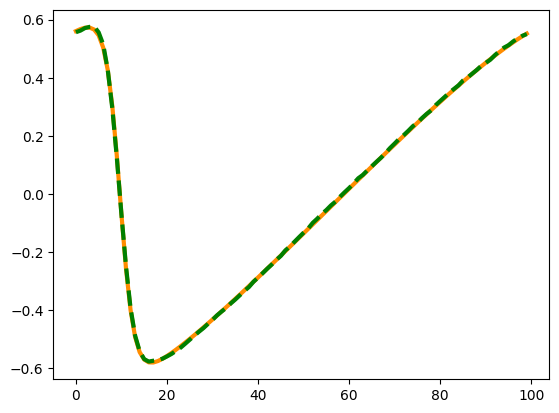

In [40]:
# Prepare data
index = 50 # Time index
T0 = T[index]*np.ones(shape=(N_x))
tau0 = torch.from_numpy(T[index]*np.ones(shape=(1))).type(torch.float32).to(device).unsqueeze(dim=0)
tau0.requires_grad_()
U_test_np = np.zeros(shape=(1,N_x))
U_test_np[0,0:N_x] = u[:,0] #+ noise
U_test = torch.tensor(U_test_np, requires_grad=True).type(torch.float32).to(device)

# Pass data into neural networks
uv_test = parameterization(U_test)
g_test = g(uv_test, tau0)
enc_test = encoder(uv_test, tau0)
dec_test = decoder(enc_test)

plt.plot(u[:,index], color='darkorange', linewidth=3)
plt.plot(dec_test.squeeze().cpu().detach().numpy(), color='green', linestyle='dashed', linewidth=3)
#plt.grid(linestyle='dashed', color='lightgray')

In [33]:
pip install cmasher

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 12.2 MB/s eta 0:00:00


In [41]:
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr

def heatmap2d(u):

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

 # ax.set_axis_off()
  im = ax.imshow(u[:,:], cmap=cmr.seasons_s_r)
  ax.set_xticks([0,50,99], ['0', ' 0.5', '1'])
  ax.set_yticks([0,50,99], ['0', ' 0.5', '1'])
  ax.grid(False)

  fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.3, hspace=0.3)


  cb_ax = fig.add_axes([0.83, 0.15, 0.04, 0.7])
  cbar = fig.colorbar(im, cax=cb_ax)

  #cbar.ax.set_yticks((-10,-5,0,5,10))

  plt.savefig('burgers.png', dpi=700)
  plt.show()

In [42]:
# Get test results over a 2d grid (space and time)

u_solution_test_2d = np.zeros(shape=(N_x,N_t))

for i in range(N_t):
  tau0 = torch.from_numpy(T[i]*np.ones(shape=(1))).type(torch.float32).to(device).unsqueeze(dim=0)
  U_test_np = np.zeros(shape=(1,N_x))
  U_test_np[0,0:N_x] = u[:,0]
  U_test = torch.tensor(U_test_np, requires_grad=True).type(torch.float32).to(device)

  uv_test = parameterization(U_test)
  enc_test = encoder(uv_test, tau0)
  dec_test = decoder(enc_test)
  u_solution_test_2d[:,i] = dec_test.cpu().detach().numpy()

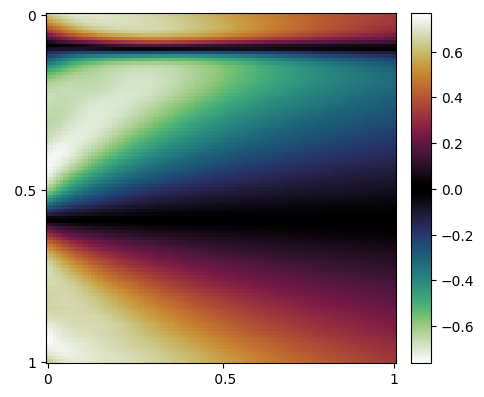

In [43]:
heatmap2d(u_solution_test_2d)

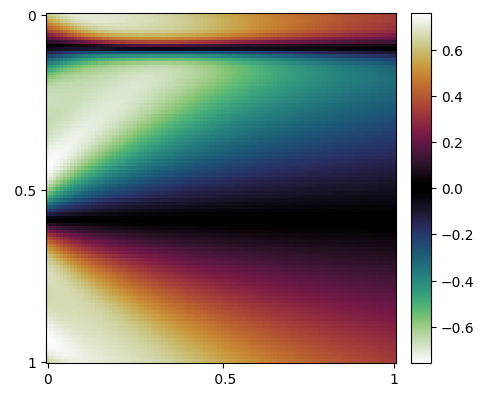

In [44]:
heatmap2d(u)

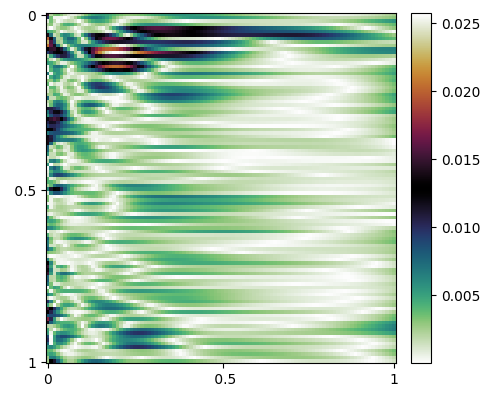

In [45]:
heatmap2d( np.abs( u_solution_test_2d - u ) )

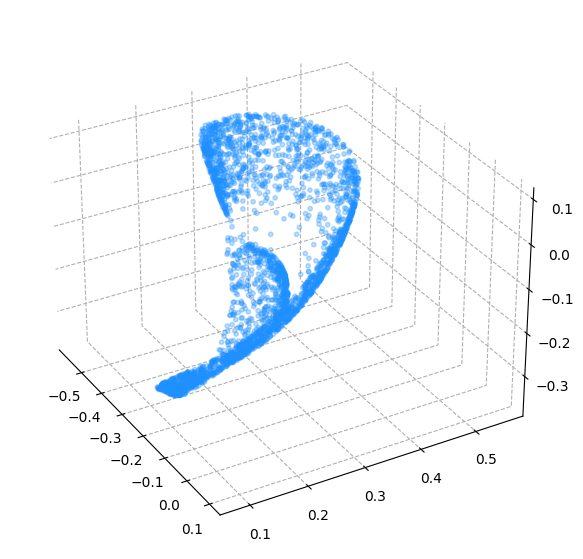

In [46]:
# Plot manifold

u = parameterization(U[::100,:])
manifold_time = 0.8*torch.ones(size=(num_samples,1)).to(device) # Choose time to display
manifold = encoder(u,manifold_time)

manifold_x = manifold[:,0].cpu().detach().numpy()
manifold_y = manifold[:,1].cpu().detach().numpy()
manifold_z = manifold[:,2].cpu().detach().numpy()

plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")
ax.scatter3D(manifold_x, manifold_y, manifold_z, color='dodgerblue', alpha=0.3, s=10)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['linestyle'] = "dashed"
ax.yaxis._axinfo["grid"]['linestyle'] = "dashed"
ax.zaxis._axinfo["grid"]['linestyle'] = "dashed"


#ax.view_init(30, -60)
ax.view_init(30, -30)


plt.savefig("manifold.png", dpi=500)
plt.show()